In [1]:
import os
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import parmap 
import shutil
from sklearn.model_selection import train_test_split

In [2]:
seed_number = 42
random.seed(seed_number)
np.random.seed(seed_number)

In [3]:
root_path = '/workspace/ssd/AI_hub/speech_recognition/'

In [99]:
wav_files = []

In [ ]:
def process_audio_function(wav_file):
    y, sr = librosa.load(wav_file, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    return sr, duration

In [100]:
for root, _, files in os.walk(root_path):
    for file in files:
        if file.endswith('.wav'):
            wav_files.append(os.path.join(root,file))

In [101]:
# 파일 수 및 기본 정보 확인
print(f"Total number of WAV files: {len(wav_files)}")
print(f"number of CPU : {cpu_count()}")

Total number of WAV files: 6610131
number of CPU : 32


In [42]:
result = parmap.map(process_audio_function, wav_files, pm_pbar=True, pm_processes=16)

  0%|          | 0/6610131 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 14%|█▍        | 929556/6610131 [01:14<03:57, 23962.48it/s]/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
6610176it [04:09, 26454.96it/s]                             


In [45]:
lengths = []
sample_rates = []

In [46]:
for sample_rate, second in result:
    sample_rates.append(sample_rate)
    lengths.append(second)

In [47]:
# 데이터프레임으로 변환
df = pd.DataFrame({
    'file_path': wav_files,
    'length': lengths,
    'sample_rate': sample_rates
})

In [88]:
# 80%, 90% 백분위수 계산
percentiles = df['length'].quantile([0.80, 0.85, 0.867, 0.90])
print(percentiles)

0.800    3.88
0.850    4.68
0.867    5.00
0.900    5.63
Name: length, dtype: float64


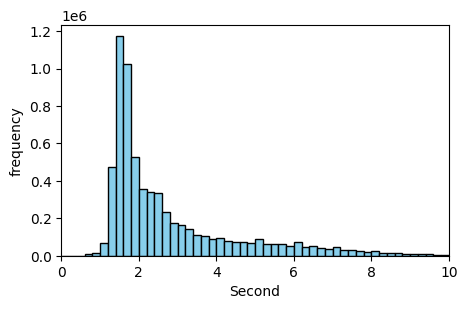

In [65]:
plt.figure(figsize=(5, 3))
plt.hist(df['length'], color='skyblue',edgecolor='black',bins=50, range=(0,10))
plt.xlim(0, 10)
plt.xlabel('Second')
plt.ylabel('frequency')
plt.show()

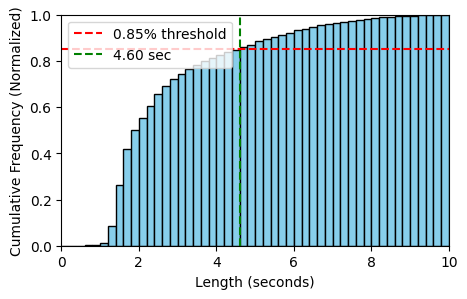

In [90]:
which_percent = 0.85

plt.figure(figsize=(5, 3))
counts, bin_edges, _ = plt.hist(df['length'], bins=50, color='skyblue', edgecolor='black', range=(0, 10), cumulative=True, density=True)

# 누적 분포 함수 (CDF) 계산
cdf = counts / counts[-1]  # 정규화된 누적 분포 함수

eighty_percent_idx = (cdf >= which_percent).argmax()
eighty_percent_value = bin_edges[eighty_percent_idx]

plt.xlabel('Length (seconds)')
plt.ylabel('Cumulative Frequency (Normalized)')
plt.xlim(0, 10)
plt.ylim(0, 1)  # y축을 0에서 1로 설정
plt.axhline(y=which_percent, color='red', linestyle='--', label=f'{which_percent}% threshold')
plt.axvline(x=eighty_percent_value, color='green', linestyle='--', label=f'{eighty_percent_value:.2f} sec')
plt.legend()

plt.show()

In [113]:
speaker_files = {}

In [115]:
for wav_file in wav_files:
    speaker_dir = os.path.dirname(wav_file)
    if speaker_dir not in speaker_files:
        speaker_files[speaker_dir] = []
    speaker_files[speaker_dir].append(file)

In [117]:
len(speaker_files)
for i in speaker_files.keys():
    print(i)
    break

/workspace/ssd/AI_hub/speech_recognition/dataset/2.Validation/source_data/VS_continuous_01/continuous/2022-01-04/3492


# Train, Validation, Test Split For Speakers

In [118]:
root_path = '/workspace/ssd/AI_hub/speech_recognition/dataset/'

In [121]:
person_dir = os.path.join(root_path, 'person')
os.makedirs(person_dir, exist_ok=True)
print(person_dir)

/workspace/ssd/AI_hub/speech_recognition/dataset/person


In [129]:
speaker_datas = {}
for file in tqdm(wav_files):
    speaker_dir = os.path.dirname(file)
    person_id = speaker_dir.split('/')[-1]
    if person_id not in speaker_datas:
        speaker_datas[person_id] = []
    speaker_datas[person_id].append(file)

100%|██████████| 6610131/6610131 [00:07<00:00, 933432.06it/s]


In [140]:
for person_id, each_person_files in tqdm(speaker_datas.items()):
    person_folder = os.path.join(person_dir, person_id)
    os.makedirs(person_folder, exist_ok=True)

    for each_file in each_person_files:
        new_file_path = os.path.join(person_folder, os.path.basename(each_file))
        shutil.move(each_file, new_file_path)
    
print(f'Total persons processed: {len(speaker_datas)}')

100%|██████████| 3101/3101 [01:12<00:00, 43.02it/s] 

Total persons processed: 3101


## DataEDA

In [4]:
person_dir

NameError: name 'person_dir' is not defined

In [150]:
# check number of wav file each speakers
speaker_datas = {}
for root, _, files in os.walk(person_dir):
    person_id = os.path.basename(root)
    
    if person_id.isdigit():
        wavfiles = [file for file in files if file.endswith('.wav')]
        speaker_datas[person_id] = len(wavfiles)

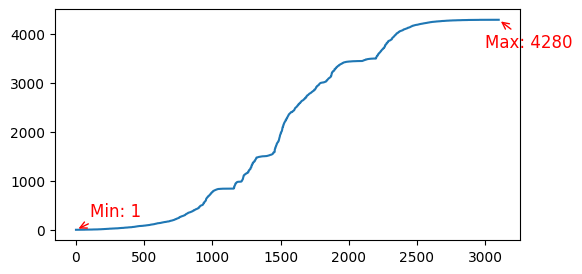

In [168]:
sorted_wav_counts = sorted(speaker_datas.values())

plt.figure(figsize=(6, 3))
plt.plot(sorted_wav_counts)

# 최소값 표시
plt.annotate(f'Min: {sorted_wav_counts[0]}', 
             xy=(0, sorted_wav_counts[0]), 
             xycoords='data',
             xytext=(10, 10),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=12,
             color='red')

# 최대값 표시
plt.annotate(f'Max: {sorted_wav_counts[-1]}', 
             xy=(len(sorted_wav_counts) - 1, sorted_wav_counts[-1]), 
             xycoords='data',
             xytext=(-10, -20),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=12,
             color='red')

plt.show()

In [175]:
sorted_wav_df = pd.DataFrame({
    'num_wav': sorted_wav_counts
})

In [177]:
sorted_wav_df.describe()

,num_wav
count,3101.000000
mean,2131.612706
std,1683.841708
min,1.000000
25%,277.000000
50%,2296.000000
75%,3921.000000
max,4280.000000


In [203]:
sorted_wav_df.quantile([0.05, 0.76])

,num_wav
0.05,9.0
0.76,4008.0


In [204]:
## wav to txt 

In [3]:
# 데이터셋 폴더 경로 설정
root_path = '/workspace/ssd/AI_hub/speech_recognition/dataset/'
person_dir = '/workspace/ssd/AI_hub/speech_recognition/dataset/person'
output_dir = '/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths'
os.makedirs(output_dir, exist_ok=True)

In [4]:
speaker_datas = {}
for root, _, files in os.walk(person_dir):
    person_id = os.path.basename(root)

    if person_id.isdigit():
        wavfiles = [os.path.join(root, file) for file in files if file.endswith('.wav')]
        if wavfiles:
            speaker_datas[person_id] = wavfiles

In [5]:
len(speaker_datas)

3101

In [6]:
## Filter data 
min_sample = 10
filtered_data = {speaker: files for speaker, files in speaker_datas.items() if len(files)>=min_sample}
len(filtered_data)

2939

In [7]:
for speaker, files in filtered_data.items():
    file_path = os.path.join(output_dir, f"{speaker}.txt")
    
    with open(file_path, 'w') as f:
        for file in files:
            f.write(f"{file}\n")

In [8]:
## Train, Valid, Test Split
seed_number = 42

In [14]:
train_file = os.path.join(root_path, 'train.txt')
valid_file = os.path.join(root_path, 'valid.txt')
test_file = os.path.join(root_path, 'test.txt')

In [13]:
txt_files = sorted([os.path.join(output_dir, file) for file in os.listdir(output_dir) if file.endswith('.txt')])
txt_files[:5], len(txt_files)

(['/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths/0000.txt',
  '/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths/0001.txt',
  '/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths/0002.txt',
  '/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths/0003.txt',
  '/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths/0004.txt'],
 2939)

In [15]:
train_files, temp_files = train_test_split(txt_files, test_size=0.2, random_state=seed_number)
valid_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=seed_number)

In [16]:
print(f"train_files : {len(train_files)}, valid_files: {len(valid_files)}, test_files: {len(test_files)}")

train_files : 2351, valid_files: 294, test_files: 294


In [17]:
train_files[0]

'/workspace/ssd/AI_hub/speech_recognition/dataset/file_paths/0576.txt'

In [18]:
def save_split_data(file_path, data):
    with open(file_path, 'w') as f:
        for item in data:
            f.write(f"{item}\n")

In [19]:
# 파일 경로 저장
save_split_data(train_file, train_files)
save_split_data(valid_file, valid_files)
save_split_data(test_file, test_files)